[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -0.250726
[LightGBM] [Info] Start training from score -1.974552
[LightGBM] [Info] Start training from score -2.489624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Random Forest Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96       332
     Suspect       0.85      0.68      0.75        59
Pathological       0.86      0.86      0.86        35

    accuracy                           0.93       426
   macro avg       0.88    

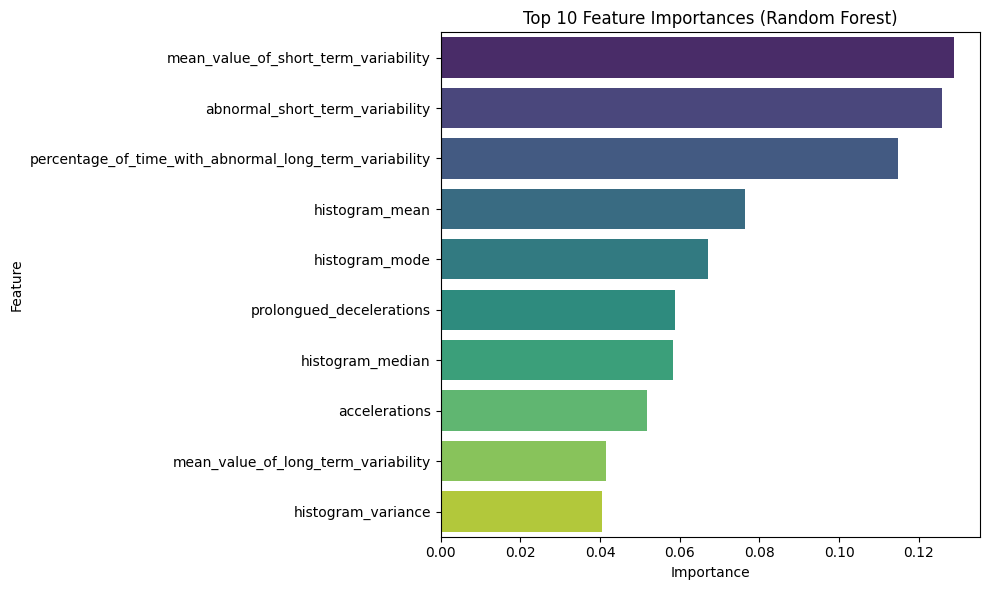

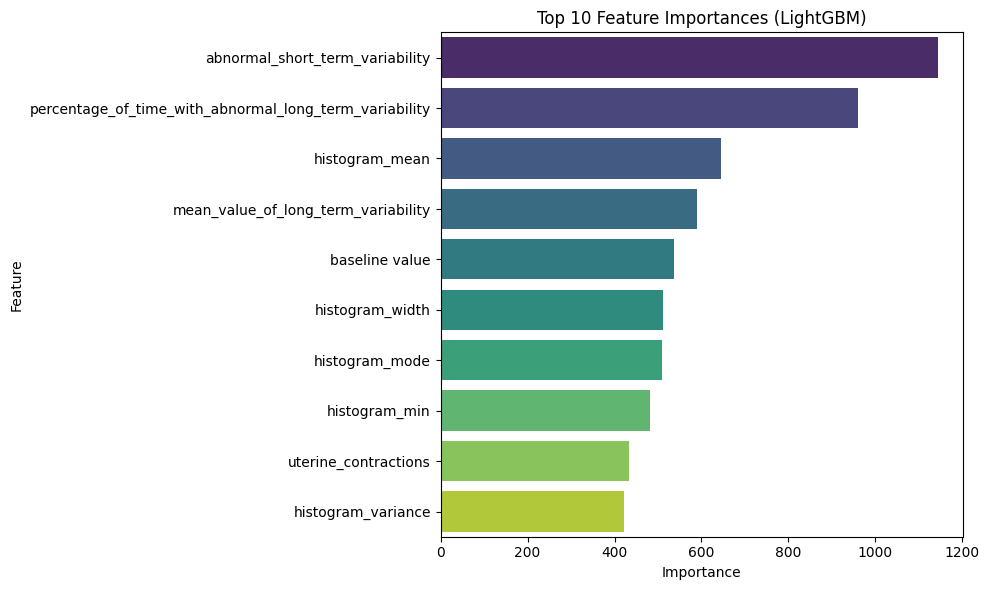

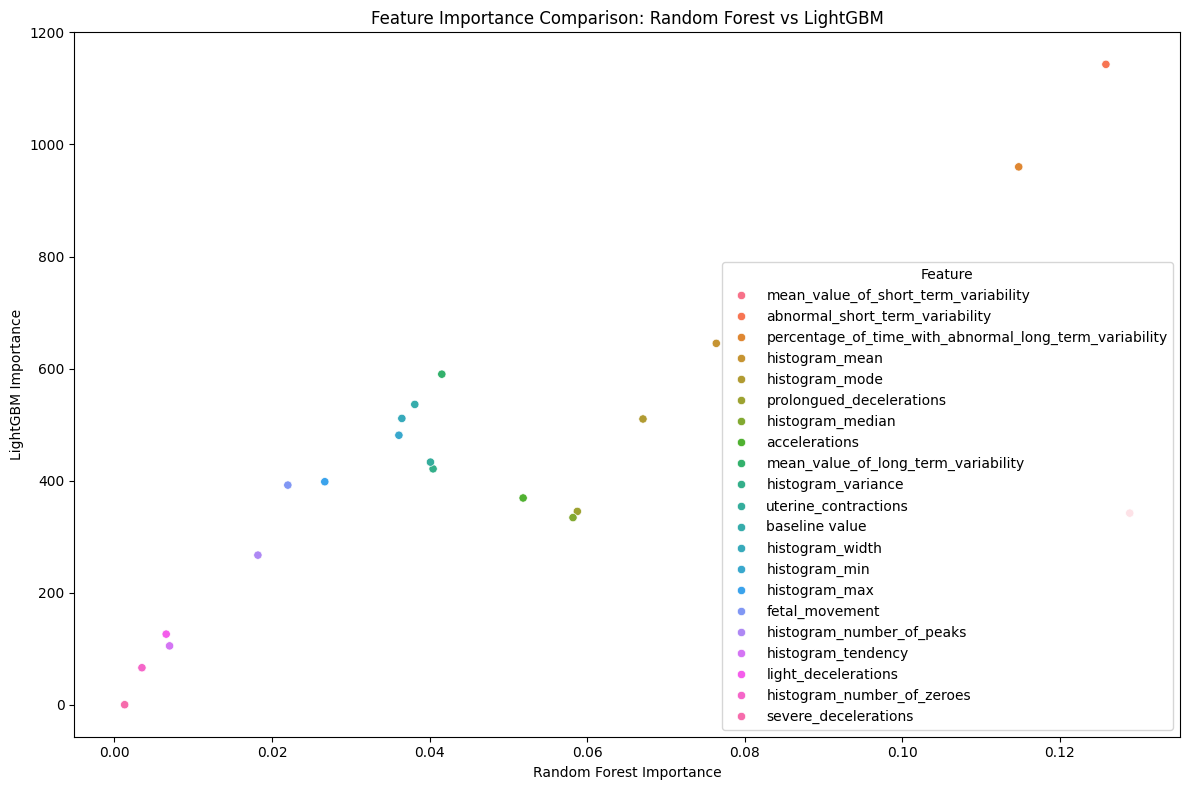

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import time

# Load the dataset
data = pd.read_csv('/content/fetal_health.csv')  # Update the path if necessary

# Separate features and target variable
X = data.drop(columns=['fetal_health'])
y = data['fetal_health']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, random_state=42)

# Train Random Forest
start_time_rf = time.time()
rf.fit(X_train_scaled, y_train)
rf_time = time.time() - start_time_rf

# Train LightGBM
start_time_lgbm = time.time()
lgbm.fit(X_train_scaled, y_train)
lgbm_time = time.time() - start_time_lgbm

# Predictions
y_pred_rf = rf.predict(X_test_scaled)
y_pred_lgbm = lgbm.predict(X_test_scaled)

# Classification Reports
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Suspect', 'Pathological']))

print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrices
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

# AUC-ROC Scores (if applicable)
if len(np.unique(y)) == 2:  # AUC only applies for binary classification
    print("Random Forest AUC-ROC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))
    print("LightGBM AUC-ROC:", roc_auc_score(y_test, lgbm.predict_proba(X_test_scaled)[:, 1]))

# Training Times
print(f"Random Forest Training Time: {rf_time:.2f} seconds")
print(f"LightGBM Training Time: {lgbm_time:.2f} seconds")

# Feature Importance Comparison
# Random Forest Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# LightGBM Feature Importance
lgbm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lgbm_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()


# Comparative Visualization
importance_comparison = pd.merge(
    rf_importances, lgbm_importances, on='Feature', suffixes=('_RF', '_LGBM')
)

# Scatter Plot Comparison
plt.figure(figsize=(12, 8))
sns.scatterplot(data=importance_comparison, x='Importance_RF', y='Importance_LGBM', hue='Feature')
plt.title('Feature Importance Comparison: Random Forest vs LightGBM')
plt.xlabel('Random Forest Importance')
plt.ylabel('LightGBM Importance')
plt.tight_layout()
plt.show()
